{/* cspell:ignore eigenphase topk ylab boxstyle fontsize */}

# Quantum Phase Estimation with Q-CTRL's Qiskit Functions

*Usage estimate: 40 seconds on a Heron r2 processor. (NOTE: This is an estimate only. Your runtime may vary.)*

## Background
Quantum Phase Estimation (QPE) is a foundational algorithm in quantum computing, forming the basis of many important applications such as Shor’s algorithm, quantum chemistry ground-state energy estimation, and eigenvalue problems.  QPE estimates the phase $\varphi$ associated with an eigenstate of a unitary operator, encoded in the relation:

$$ U \lvert \varphi \rangle = e^{2\pi i \varphi} \lvert \varphi \rangle, $$

and determines it to a precision of $\epsilon = O(1/2^m)$ using $m$ counting qubits. By preparing these qubits in superposition, applying controlled powers of $U$, and then using the inverse Quantum Fourier Transform (QFT) to extract the phase into binary-encoded measurement outcomes, QPE produces a probability distribution peaked at bitstrings whose binary fractions approximate $\varphi$. In the ideal case, the most likely measurement outcome directly corresponds to the binary expansion of the phase, while the probability of other outcomes decreases rapidly with the number of counting qubits. However, running deep QPE circuits on hardware presents challenges: the large number of qubits and entangling operations make the algorithm highly sensitive to decoherence and gate errors. This results in broadened and shifted distributions of bitstrings, masking the true eigenphase. As a consequence, the bitstring with the highest probability may no longer correspond to the correct binary expansion of  $\varphi$.

In this tutorial, we present an implementation of the Quantum Phase Estimation (QPE) algorithm using Q-CTRL's Fire Opal error suppression and performance management tools, offered as a Qiskit Function (see the [Fire Opal documentation](/docs/guides/q-ctrl-performance-management)). Fire Opal automatically applies advanced optimizations including dynamical decoupling, qubit layout improvements, and error suppression techniques, resulting in higher-fidelity outcomes. These improvements bring hardware bitstring distributions closer to those obtained in noiseless simulations, enabling reliable identification of the correct eigenphase even under the effects of noise.

## Requirements

Before starting this tutorial, be sure you have the following installed:
- Qiskit SDK v1.4 or later, with visualization support ( `pip install 'qiskit[visualization]'` )
- Qiskit Runtime v0.40 or later (`pip install qiskit-ibm-runtime`)
- Qiskit Functions Catalog v0.9.0 (`pip install qiskit-ibm-catalog`)
- Fire Opal SDK v9.0.2 or later (`pip install fire-opal`)
- Q-CTRL Visualizer v8.0.2 or later (`pip install qctrl-visualizer`)

## Setup

In [5]:
from qiskit import QuantumCircuit

import numpy as np
import matplotlib.pyplot as plt
import qiskit
from qiskit import qasm2
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
import qctrlvisualizer as qv
from qiskit_ibm_catalog import QiskitFunctionsCatalog

plt.style.use(qv.get_qctrl_style())

In [ ]:
# Set credentials.
token = "YOUR_IBM_CLOUD_API_KEY"
instance = "YOUR_IBM_CRN"

catalog = QiskitFunctionsCatalog(
    channel="ibm_quantum_platform", instance=instance, token=token
)

# Access Function
perf_mgmt = catalog.load("q-ctrl/performance-management")

## Step 1: Map classical inputs to a quantum problem

We begin by defining the building blocks QPE needed to implement Quantum Phase Estimation. These include the Quantum Fourier Transform (QFT) and its inverse, which translate phase information into measurable bitstrings, along with utility functions to convert between decimal and binary fractions of the target eigenphase. Additional helpers are provided to normalize raw counts into probabilities and reformat distributions, enabling direct comparison between simulation and hardware results.

In [7]:
def inverse_quantum_fourier_transform(quantum_circuit, number_of_qubits):
    """
    Apply an inverse Quantum Fourier Transform the first `number_of_qubits` qubits in the
    `quantum_circuit`.
    """
    for qubit in range(number_of_qubits // 2):
        quantum_circuit.swap(qubit, number_of_qubits - qubit - 1)
    for j in range(number_of_qubits):
        for m in range(j):
            quantum_circuit.cp(-np.pi / float(2 ** (j - m)), m, j)
        quantum_circuit.h(j)
    return quantum_circuit

In [8]:
def bitstring_count_to_probabilities(data, shot_count):
    """
    This function turns an unsorted dictionary of bitstring counts into a sorted dictionary
    of probabilities.
    """
    # Turn the bitstring counts into probabilities.
    probabilities = {
        bitstring: bitstring_count / shot_count
        for bitstring, bitstring_count in data.items()
    }

    sorted_probabilities = dict(
        sorted(probabilities.items(), key=lambda x: x[1], reverse=True)
    )

    return sorted_probabilities

## Step 2: Optimize problem for quantum hardware execution

We build the QPE circuit by preparing the counting qubits in superposition, applying controlled phase rotations to encode the target eigenphase, and finishing with an inverse QFT before measurement.

In [9]:
def quantum_phase_estimation_benchmark_circuit(number_of_counting_qubits, phase):
    """
    Create the circuit for quantum phase estimation.

    Parameters
    ----------
    number_of_counting_qubits : The number of qubits in the circuit.
    phase : The desired phase.

    Returns
    -------
    QuantumCircuit
        The quantum phase estimation circuit for `number_of_counting_qubits` qubits.
    """
    qc = QuantumCircuit(number_of_counting_qubits + 1, number_of_counting_qubits)
    target = number_of_counting_qubits

    # |1> eigenstate for the single-qubit phase gate
    qc.x(target)

    # Hadamards on counting register
    for q in range(number_of_counting_qubits):
        qc.h(q)

    # ONE controlled phase per counting qubit: cp(phase * 2**k)
    for k in range(number_of_counting_qubits):
        qc.cp(phase * (1 << k), k, target)

    qc.barrier()

    # Inverse QFT on counting register
    inverse_quantum_fourier_transform(qc, number_of_counting_qubits)

    qc.barrier()
    for q in range(number_of_counting_qubits):
        qc.measure(q, q)
    return qc

## Step 3: Execute using Qiskit primitives

We set the number of shots and qubits for the experiment, and encode the target phase $\varphi = 1/6$ using $m$ binary digits. With these parameters, we build the QPE circuit that will be executed on simulation, default hardware, and Fire Opal–enhanced backends.

In [10]:
shot_count = 10000
num_qubits = 35
phase = (1 / 6) * 2 * np.pi
circuits_quantum_phase_estimation = quantum_phase_estimation_benchmark_circuit(
    number_of_counting_qubits=num_qubits, phase=phase
)

### Run MPS simulation
First, we generate a reference distribution using the `matrix_product_state` simulator and convert the counts into normalized probabilities for later comparison with hardware results.

In [11]:
# Run the algorithm on the IBM Aer simulator.
aer_simulator = AerSimulator(method="matrix_product_state")

# Transpile the circuits for the simulator.
transpiled_circuits = qiskit.transpile(circuits_quantum_phase_estimation, aer_simulator)

In [12]:
simulated_result = (
    aer_simulator.run(transpiled_circuits, shots=shot_count).result().get_counts()
)

In [13]:
simulated_result_probabilities = []

simulated_result_probabilities.append(
    bitstring_count_to_probabilities(
        simulated_result,
        shot_count=shot_count,
    )
)

### Run on hardware

In [ ]:
service = QiskitRuntimeService()
backend = service.backend("ibm_kingston")

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuits = pm.run(circuits_quantum_phase_estimation)

In [15]:
# Run the algorithm with IBM default.
sampler = Sampler(backend)

# Run all circuits using Qiskit Runtime.
ibm_default_job = sampler.run([isa_circuits], shots=shot_count)

### Run on hardware with Fire Opal

In [17]:
# Run the circuit using the sampler
fire_opal_job = perf_mgmt.run(
    primitive="sampler",
    pubs=[qasm2.dumps(circuits_quantum_phase_estimation)],
    backend_name="ibm_kingston",
    options={"default_shots": shot_count},
)

## Step 4: Post-process and return result in desired classical format

In [ ]:
# Retrieve results.
ibm_default_result = ibm_default_job.result()
ibm_default_probabilities = []

for idx, pub_result in enumerate(ibm_default_result):
    ibm_default_probabilities.append(
        bitstring_count_to_probabilities(
            pub_result.data.c0.get_counts(),
            shot_count=shot_count,
        )
    )

In [ ]:
fire_opal_result = fire_opal_job.result()

fire_opal_probabilities = []
for idx, pub_result in enumerate(fire_opal_result):
    fire_opal_probabilities.append(
        bitstring_count_to_probabilities(
            pub_result.data.c0.get_counts(),
            shot_count=shot_count,
        )
    )

In [16]:
data = {
    "simulation": simulated_result_probabilities,
    "default": ibm_default_probabilities,
    "fire_opal": fire_opal_probabilities,
}

In [21]:
def plot_distributions(
    data,
    number_of_counting_qubits,
    top_k=None,
    by="prob",
    shot_count=None,
):
    def nrm(d):
        s = sum(d.values())
        return {k: (v / s if s else 0.0) for k, v in d.items()}

    def as_float(d):
        return {k: float(v) for k, v in d.items()}

    def to_space(d):
        if by == "prob":
            return nrm(as_float(d))
        else:
            if shot_count and 0.99 <= sum(d.values()) <= 1.01:
                return {k: v * float(shot_count) for k, v in as_float(d).items()}
            else:
                return as_float(d)

    def topk(d, k):
        items = sorted(d.items(), key=lambda kv: kv[1], reverse=True)
        return items[: (k or len(d))]

    phase = "1/6"

    sim = to_space(data["simulation"])
    dft = to_space(data["default"])
    qct = to_space(data["fire_opal"])

    correct = max(sim, key=sim.get) if sim else None
    print("Correct result:", correct)

    sim_items = topk(sim, top_k)
    dft_items = topk(dft, top_k)
    qct_items = topk(qct, top_k)

    sim_keys, y_sim = zip(*sim_items) if sim_items else ([], [])
    dft_keys, y_dft = zip(*dft_items) if dft_items else ([], [])
    qct_keys, y_qct = zip(*qct_items) if qct_items else ([], [])

    fig, axes = plt.subplots(3, 1, layout="constrained")
    ylab = "Probabilities"

    def panel(ax, keys, ys, title, color):
        x = np.arange(len(keys))
        bars = ax.bar(x, ys, color=color)
        ax.set_title(title)
        ax.set_ylabel(ylab)
        ax.set_xticks(x)
        ax.set_xticklabels(keys, rotation=90)
        ax.set_xlabel("Bitstrings")
        if correct in keys:
            i = keys.index(correct)
            bars[i].set_edgecolor("black")
            bars[i].set_linewidth(2)
        return max(ys, default=0.0)

    c_sim, c_dft, c_qct = (
        qv.QCTRL_STYLE_COLORS[5],
        qv.QCTRL_STYLE_COLORS[1],
        qv.QCTRL_STYLE_COLORS[0],
    )
    m1 = panel(axes[0], list(sim_keys), list(y_sim), "Simulation", c_sim)
    m2 = panel(axes[1], list(dft_keys), list(y_dft), "Default", c_dft)
    m3 = panel(axes[2], list(qct_keys), list(y_qct), "Q-CTRL", c_qct)

    for ax, m in zip(axes, (m1, m2, m3)):
        ax.set_ylim(0, 1.05 * (m or 1.0))

    for ax in axes:
        ax.label_outer()
    fig.suptitle(rf"{number_of_counting_qubits} counting qubits, $2\pi\varphi$={phase}")
    fig.set_size_inches(20, 10)
    plt.show()

Correct result: 00101010101010101010101010101010101


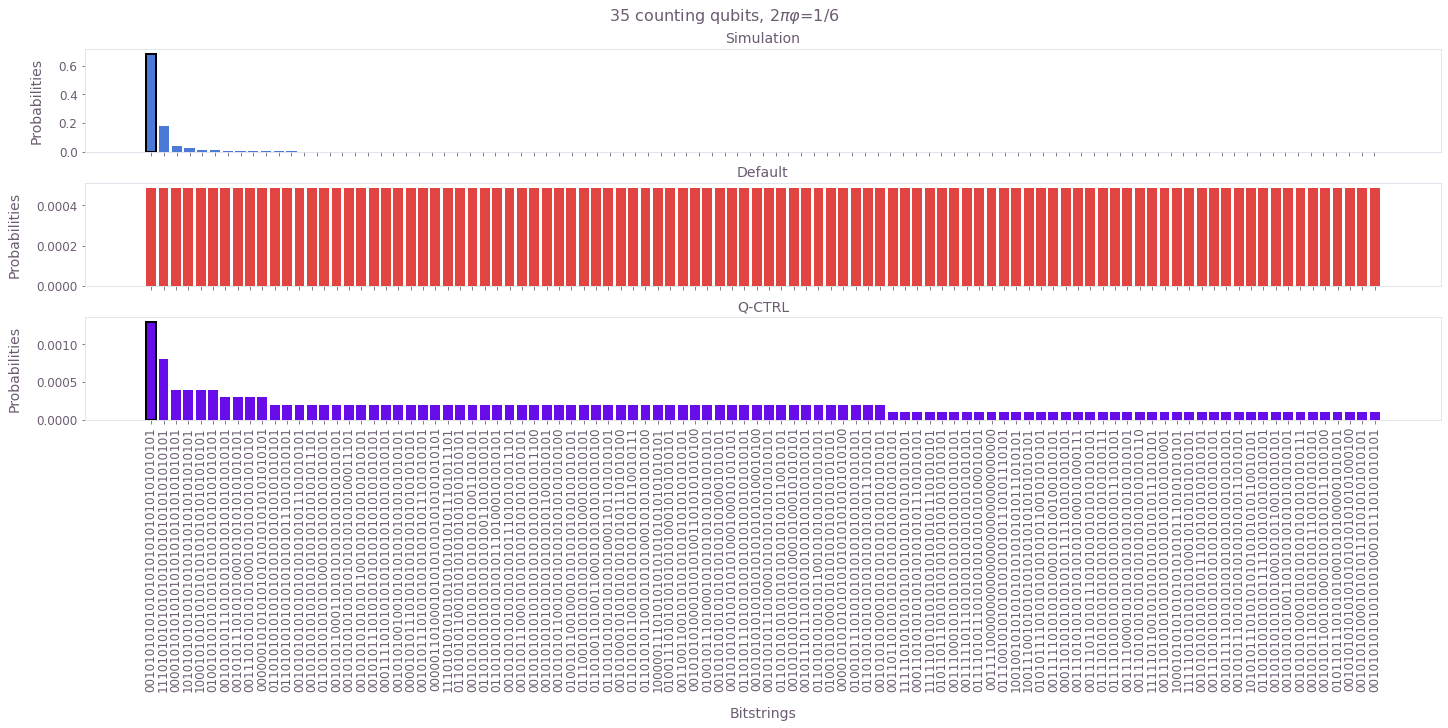

In [22]:
experiment_index = 0
phase_index = 0

distributions = {
    "simulation": data["simulation"][phase_index],
    "default": data["default"][phase_index],
    "fire_opal": data["fire_opal"][phase_index],
}

plot_distributions(
    distributions, num_qubits, top_k=100, by="prob", shot_count=shot_count
)

## Tutorial survey

Please take a minute to provide feedback on this tutorial. Your insights will help us improve our content offerings and user experience.

[Link to survey](https://your.feedback.ibm.com/jfe/form/SV_3BLFkNVEuh0QBWm)